# Benchmark for bayesian optimization

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# !cp /content/gdrive/MyDrive/00_Data_science/Notes_Gaussian_processes/test_functions.py .
# !cp /content/gdrive/MyDrive/00_Data_science/Notes_Gaussian_processes/bayes_lib.py .
# !pip install gpytorch
# !pip install botorch
from test_functions import Hart6
from bayes_lib import ExactGPModel, train_hyper_params, get_test
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.constraints import Interval
import torch
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import botorch
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.models.gpytorch import GPyTorchModel
from IPython.display import clear_output

In [35]:
# Bayes opt loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Model = ExactGPModel
likelihood = GaussianLikelihood(noise_constraint=Interval(0.0,1e-14)).to(device)

In [38]:
def gt_func(x):
    hart = botorch.test_functions.synthetic.Hartmann()
    return - hart.evaluate_true(x)

def error_gap(current_best):
    hart = botorch.test_functions.synthetic.Hartmann()
    return abs(current_best - (- hart.optimal_value))

def baseline_model(n_iter, n):
    """A model that attempts to minimize the error gap by taking n random sample over n_iter iterations"""
    results = np.zeros(n_iter)
    best_result = error_gap(gt_func(torch.randn(n*6).reshape(-1,6)).max())

    for i in range(max_iter):
        best_result = min(best_result, error_gap(gt_func(torch.randn(n*6).reshape(-1,6)).max()))
        results[i] = best_result
    return results

In [ ]:
n_exp = 10 # number of experiments
n_iter = 10 # number of iterations
print_period = 1 # results are printed every print_period iteration
n_train_ini = 20 # number of initial training examples

error_gaps = np.zeros([n_exp, max_itn_iterer])
for i_exp in range(n_exp):
    best_f = -1e5
    train_x = torch.rand(6*n_train_ini).reshape(-1,6).to(device)
    train_y = gt_func(train_x).to(device)
    for it in range(n_iter):
        # Run the forward model with hyperparam opt
        model = Model(train_x, train_y, likelihood).to(device)
        train_hyper_params(model, likelihood, training_iter=50)
        with torch.no_grad():
            # Run the aquisition method
            EI = ExpectedImprovement(model, best_f=best_f*0.1, maximize=True)
            # Add the suggested point to the training points        

            x_new = get_x_new(EI, n_test=int(5e5), n_iter=3, refinement_fac = 1.5)
            y_new = gt_func(x_new).to(device)
            best_f = max(y_new.item(), best_f)

            train_x = torch.cat((train_x.reshape(-1,1), x_new.reshape(-1,1))).reshape(-1,6)
            train_y = torch.cat((train_y.reshape(-1,1), y_new.reshape(-1,1))).reshape(-1)

            if (it+1)%print_freq == 0:
                print(f"{it+1}/{n_iter}: {best_f:.5f}, {train_y[-1].item():.5f}, {np.log10(error_gap(best_f)):.5f}")
            error_gaps[i_exp, it] = error_gap(best_f)
    clear_output()

1/10: 0.14590, 0.14590, 0.50195
2/10: 0.14590, 0.00001, 0.50195


KeyboardInterrupt: 

# Plot

In [75]:
def plot_series(X, label=''):
    means = np.mean(X,0)
    stds = np.std(X,0)
    ax.plot(means, label=label)
    ax.fill_between(np.arange(n_iter), 
                    means + 2.0*stds, 
                    means - 2.0*stds, 
                    alpha=0.2)

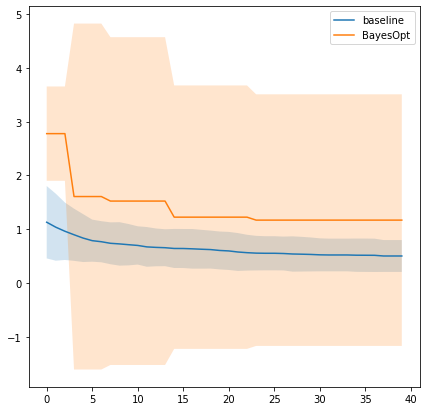

In [84]:
fig, ax = plt.subplots(1,1,figsize=[7,7])
    
plot_series(baseline_results, label='baseline')
plot_series(error_gaps, label='BayesOpt')
# ax.set_yscale('log')
plt.legend()
# plt.savefig("")